In [1]:
from datetime import date, timedelta
from constants import *
from phe import plot_areas, recent_phe_data_summed, map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import matplotlib_zoe_vs_phe_map, geoplot_bokeh, save_to_disk, bokeh_zoe_vs_phe_map
for_date = '*'

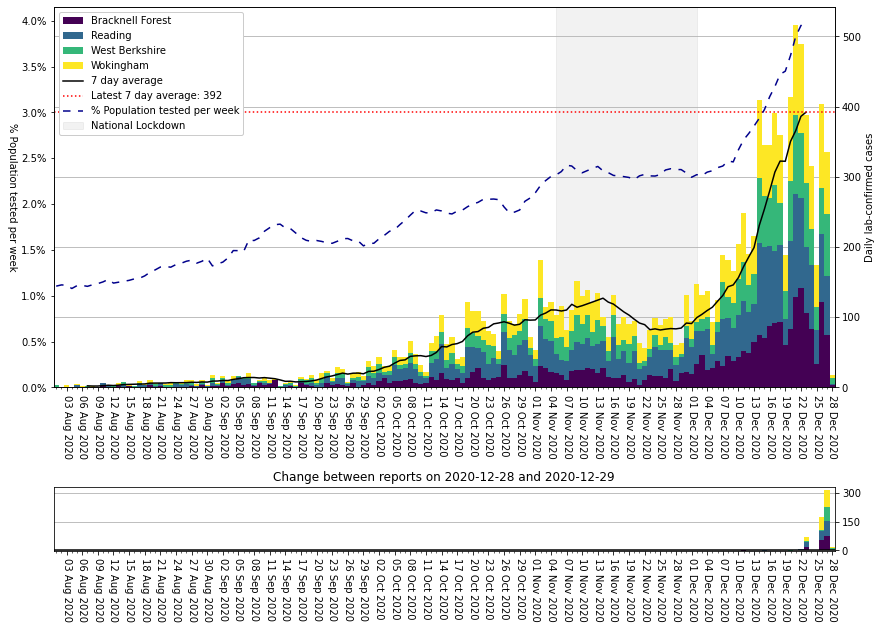

In [2]:
plot_areas(for_date, areas=my_areas)

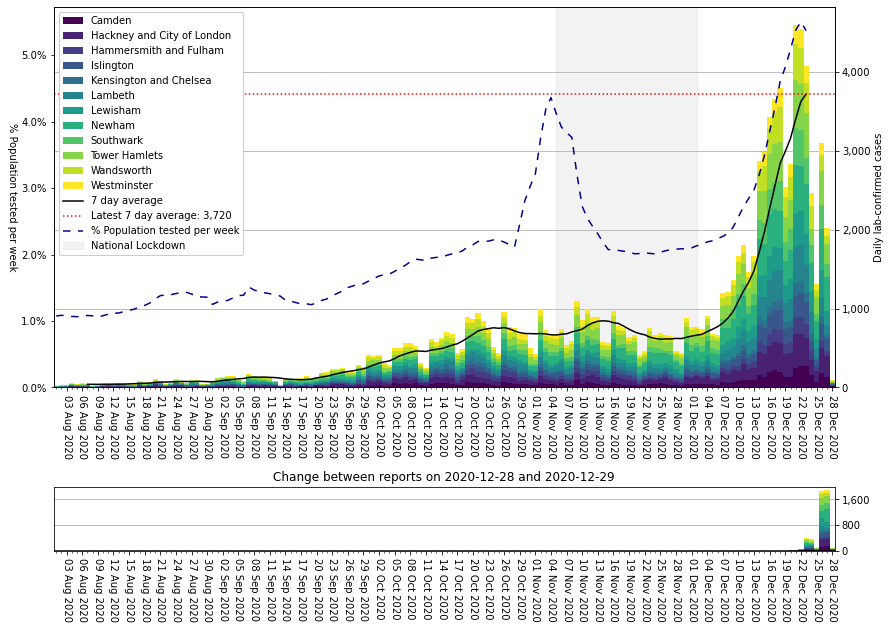

In [3]:
plot_areas(for_date, areas=london_areas)

In [4]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [5]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"cases per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000072,Epping Forest,959.077827,1263.0,2020-12-28
E07000069,Castle Point,949.367089,858.0,2020-12-28
E06000034,Thurrock,922.330376,1608.0,2020-12-28
E07000068,Brentwood,872.489321,672.0,2020-12-28
E07000095,Broxbourne,868.635574,845.0,2020-12-28
E09000026,Redbridge,840.371926,2565.0,2020-12-28
E09000016,Havering,826.423992,2145.0,2020-12-28
E07000073,Harlow,824.652279,718.0,2020-12-28
E09000002,Barking and Dagenham,799.413826,1702.0,2020-12-28


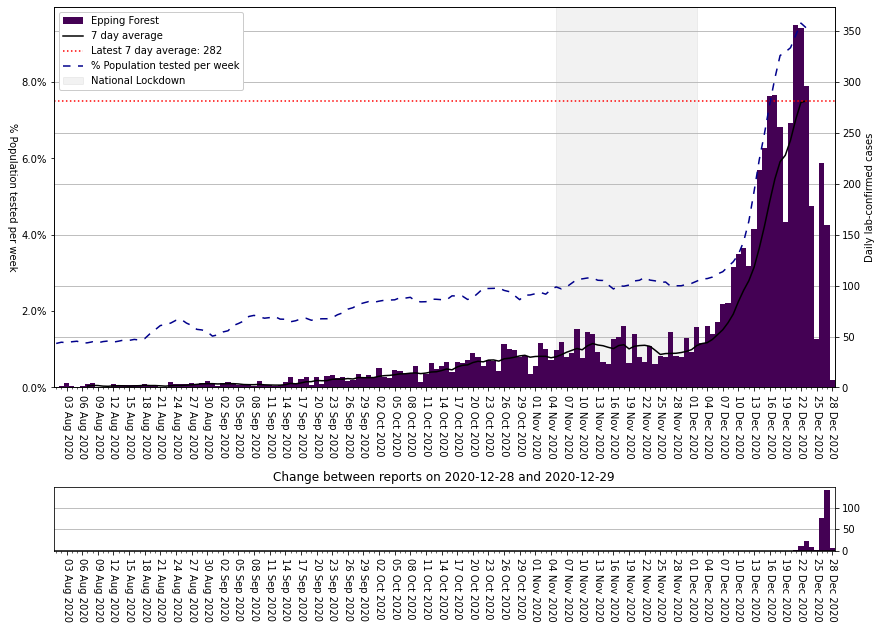

In [6]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [7]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"cases per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,281.569009,3215.0,2020-12-28
E09000025,Newham,786.953394,2779.0,2020-12-28
E09000010,Enfield,798.696202,2666.0,2020-12-28
E09000026,Redbridge,840.371926,2565.0,2020-12-28
E09000003,Barnet,608.534642,2409.0,2020-12-28
E09000008,Croydon,590.623465,2284.0,2020-12-28
E09000030,Tower Hamlets,701.473464,2278.0,2020-12-28
E09000016,Havering,826.423992,2145.0,2020-12-28
E09000006,Bromley,628.279813,2088.0,2020-12-28


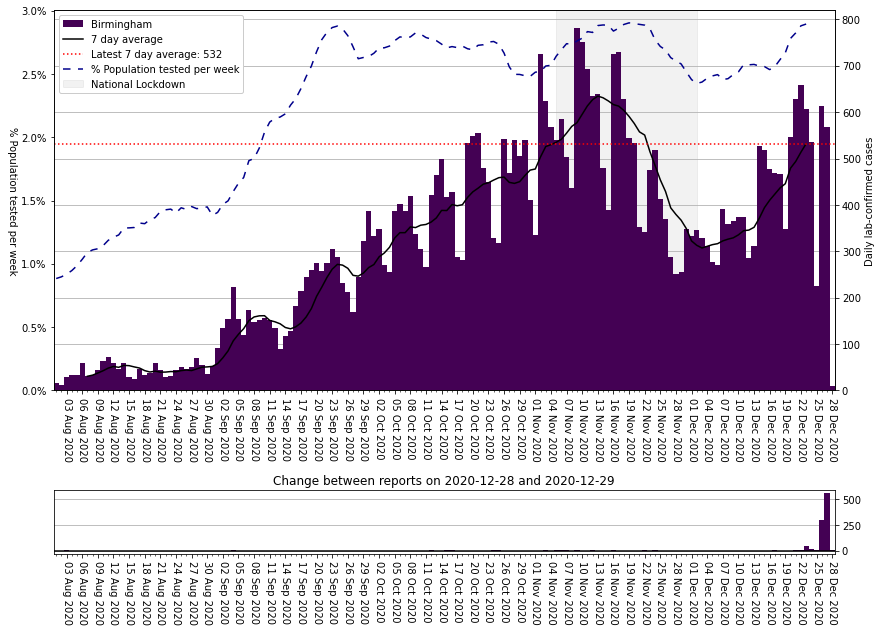

In [8]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [9]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)

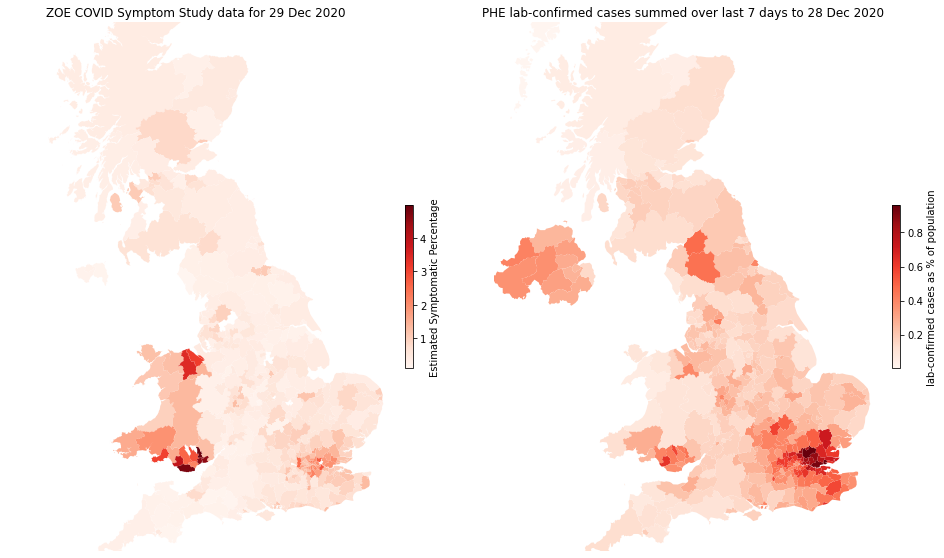

In [10]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [11]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

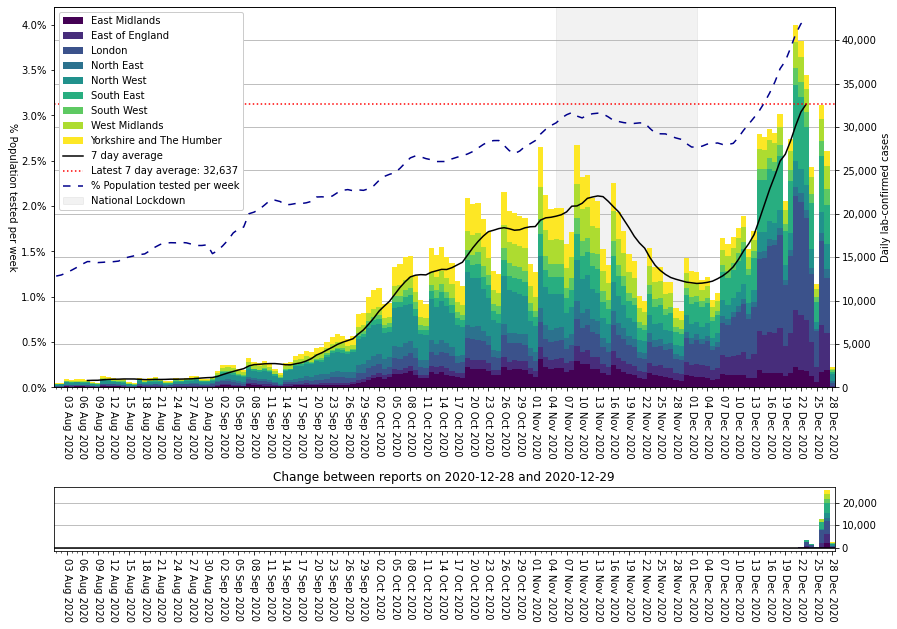

In [12]:
plot_areas(for_date, area_type=region)

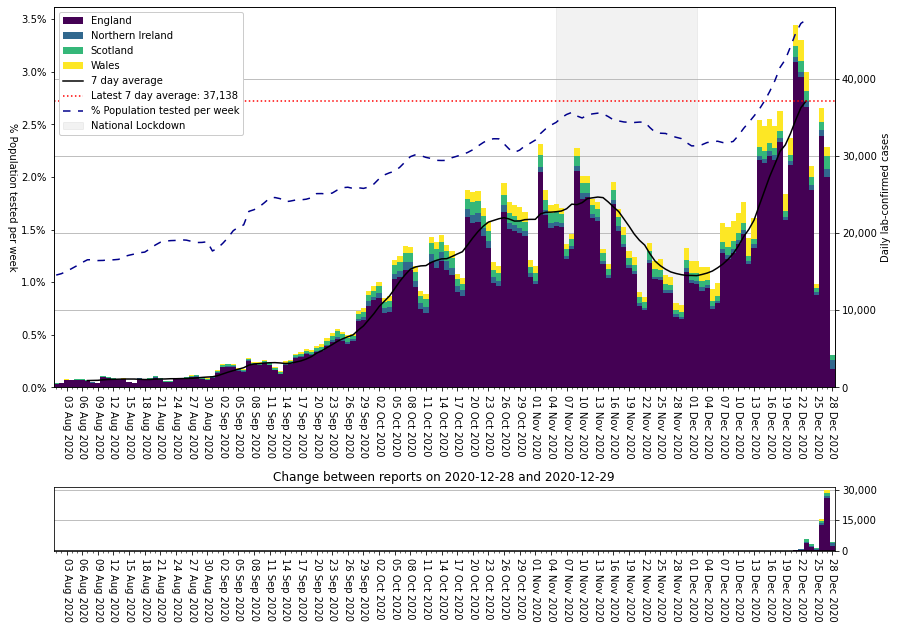

In [13]:
plot_areas(for_date, area_type=nation)